In [1]:
"""The test file tests the program and display the sky detection resluts"""

from google.colab import drive
import cv2
import os
import numpy as np
from scipy.signal import medfilt
from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

def refine_skyline(mask):
    """
    Refines the skyline in the given binary mask by adjusting column-wise transitions.
    """
    num_rows, num_cols = mask.shape

    for col_index in range(num_cols):
        current_column = mask[:, col_index]
        smoothed_column = medfilt(current_column, 19)

        try:
            first_zero_index = np.where(smoothed_column == 0)[0][0]
            first_one_index = np.where(smoothed_column == 1)[0][0]

            # Adjust skyline if there is a significant transition
            if first_zero_index > 20:
                mask[first_one_index:first_zero_index, col_index] = 1
                mask[first_zero_index:, col_index] = 0
                mask[:first_one_index, col_index] = 0

        except IndexError:
            continue

    return mask

def get_sky_region_gradient(img):
    """
    Extracts the sky region using gradient-based methods.
    """
    height, width, _ = img.shape

    # Convert the image to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Blur the image to reduce noise
    img_blurred = cv2.blur(img_gray, (9, 3))

    # Apply median blur to further reduce noise
    cv2.medianBlur(img_blurred, 5)

    # Apply Laplacian filter to enhance edges
    laplacian_output = cv2.Laplacian(img_blurred, cv2.CV_8U)

    # Create a gradient mask based on Laplacian filter output
    gradient_mask = (laplacian_output < 6).astype(np.uint8)

    # Define a morphological kernel
    morph_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 3))

    # Erode the gradient mask to remove small artifacts
    gradient_mask_eroded = cv2.morphologyEx(gradient_mask, cv2.MORPH_ERODE, morph_kernel)

    # Copy the original mask for further processing
    mask_copy = gradient_mask_eroded.copy()

    # Refine the mask using the refine_skyline function
    refined_mask = refine_skyline(mask_copy)

    # Apply the refined mask to the original image
    after_img = cv2.bitwise_and(img, img, mask=refined_mask)

    return after_img, gradient_mask_eroded

def display_binary_mask(ax, masked_image):
    """
    Displays the binary mask with white for sky and black for non-sky.
    """
    binary_mask = (masked_image > 0).astype(np.uint8) * 255
    ax.imshow(binary_mask, cmap='gray', vmin=0, vmax=255)
    ax.set_title("Binary Mask (Light Part for Sky, Black for Non-Sky)")

def get_sky_region(image_path):
    """
    Extracts and visualizes the sky region from the given image.
    """
    # Read the image
    image = cv2.imread(image_path)

    if image is not None:
        # Create a 3x1 grid for subplots
        fig, axs = plt.subplots(3, 1, figsize=(18, 12))

        # Display the original image
        axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axs[0].set_title("Original Image")

        # Skyline detection and morphological operations
        masked_image, gradient_mask = get_sky_region_gradient(image)

        # Display the masked image with gradient mask
        axs[1].imshow(masked_image)
        axs[1].set_title("Masked Image with Gradient Mask")

        # Display the binary mask as the final result
        display_binary_mask(axs[2], masked_image)

        # Display the final result
        plt.tight_layout()
        plt.show()
    else:
        print("Error: Unable to read the image.")


Mounted at /content/drive


Processing Image: paris.jpg


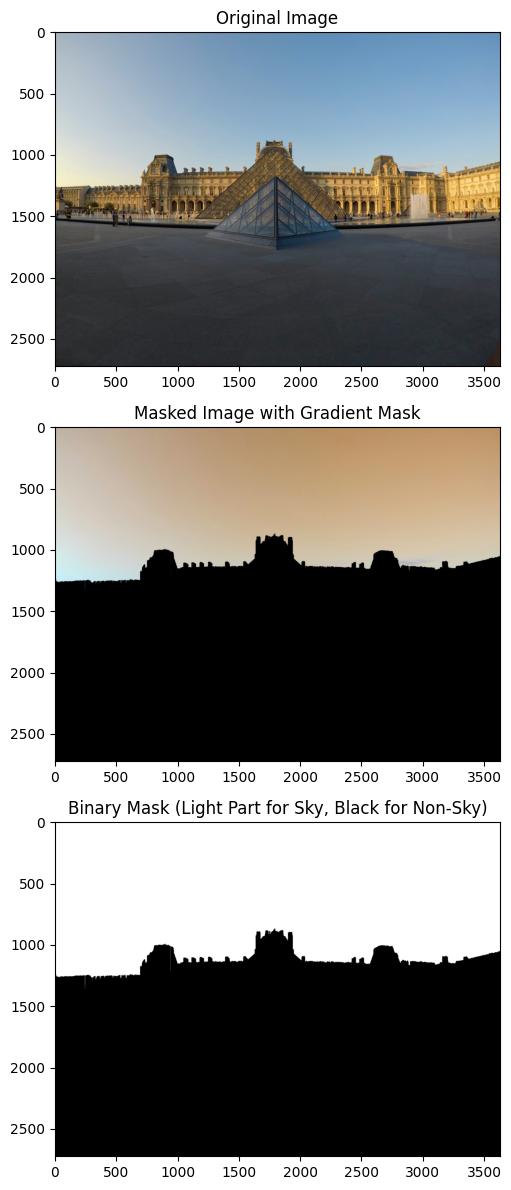

Processing Image: villa.jpg


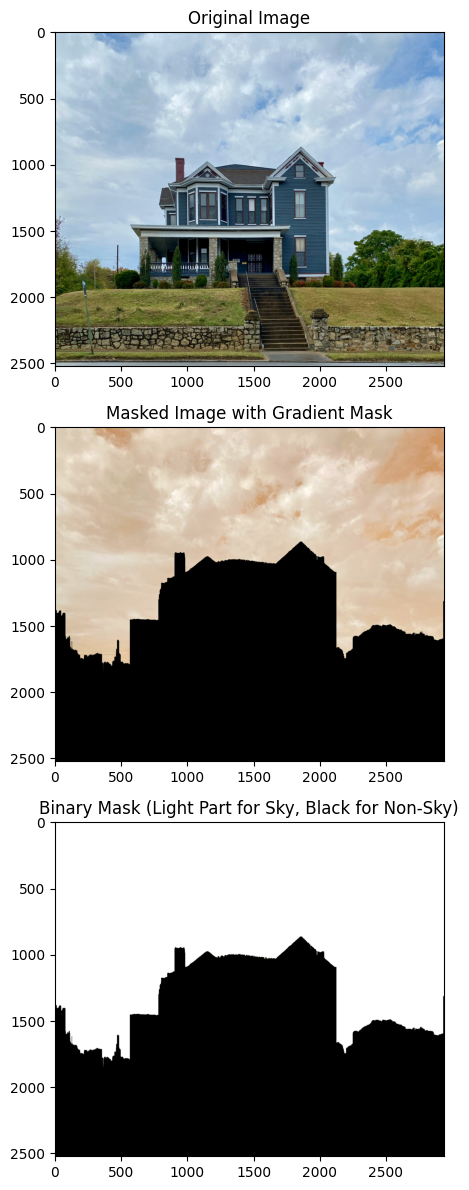

Processing Image: wood.jpg


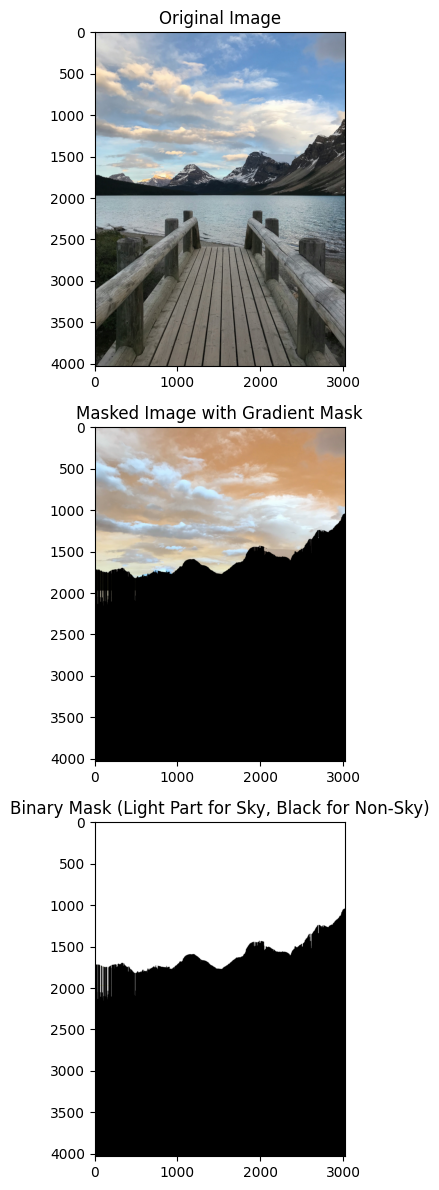

Processing Image: skyline.jpg


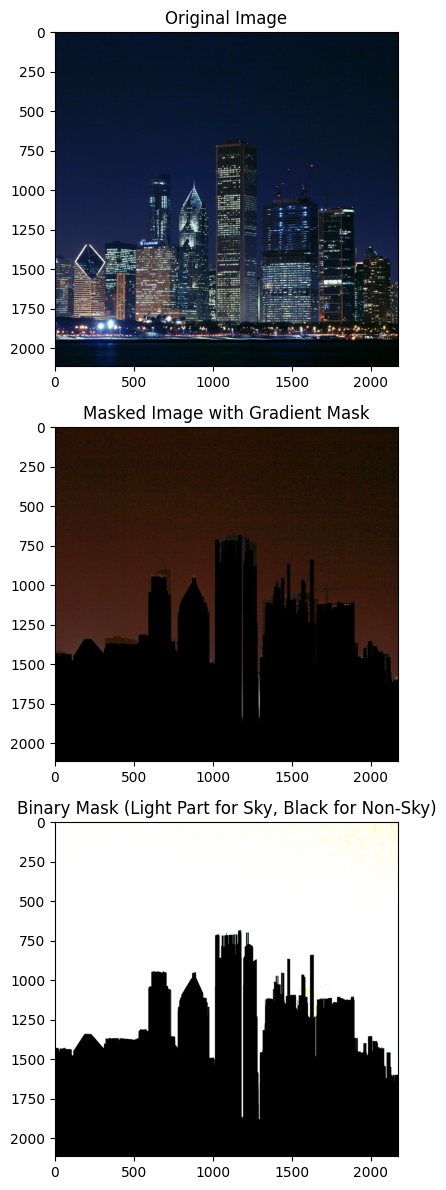

Processing Image: reflection.jpg


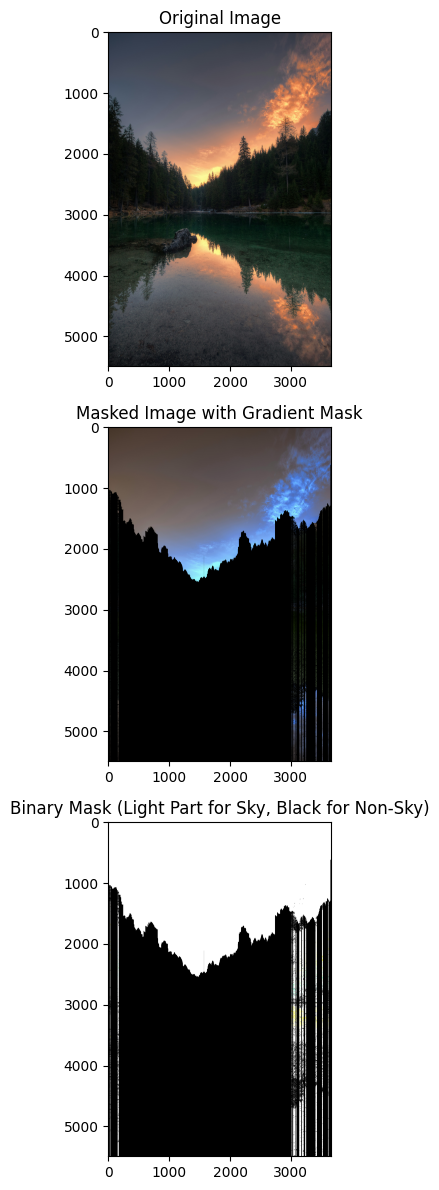

Processing Image: deck.jpg


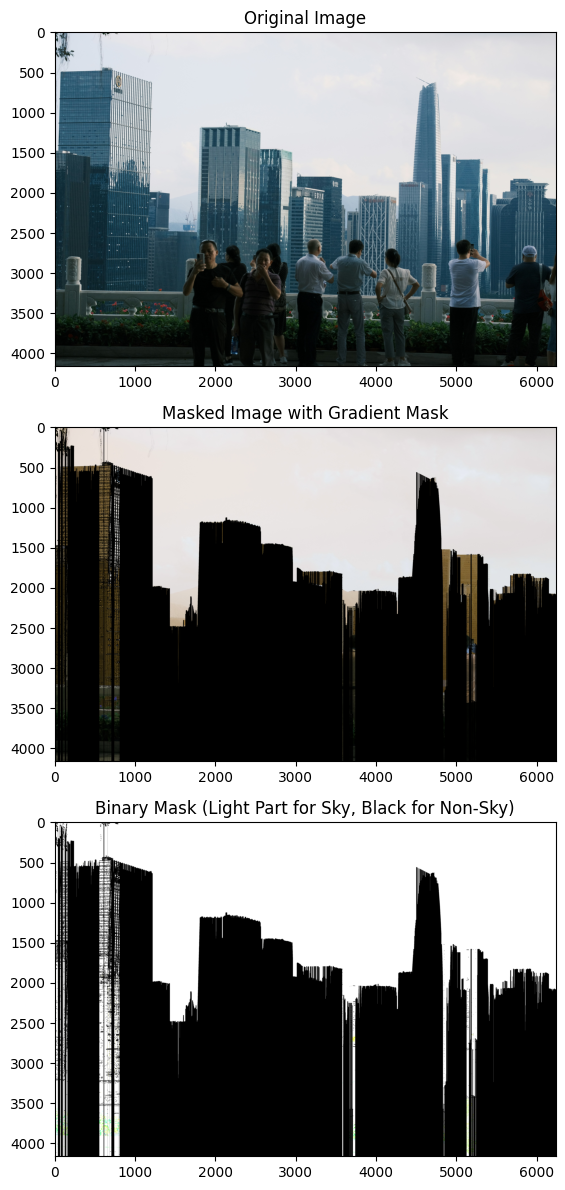

Processing Image: road.jpg


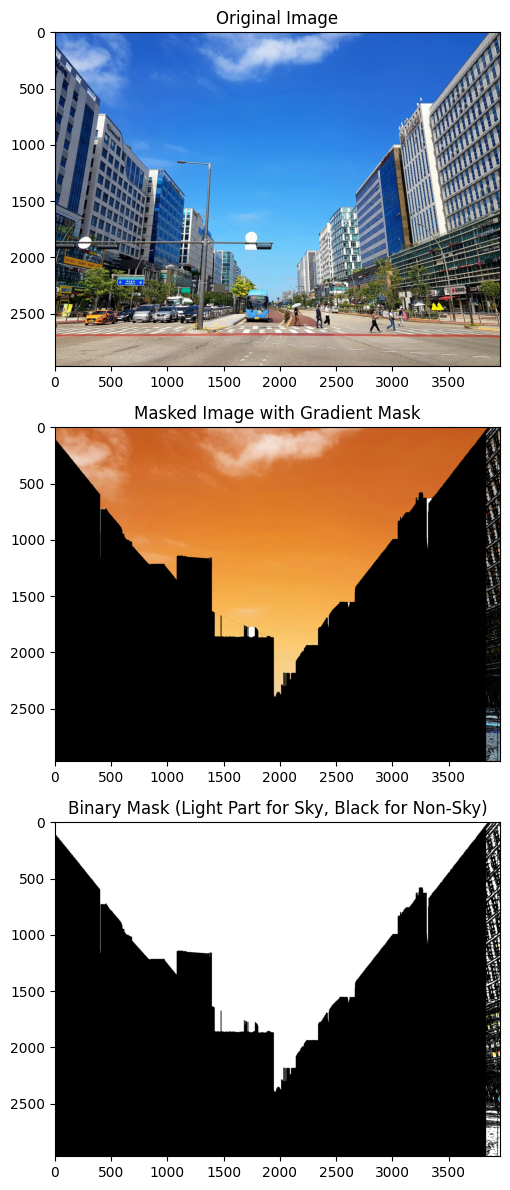

Processing Image: chicago.jpg


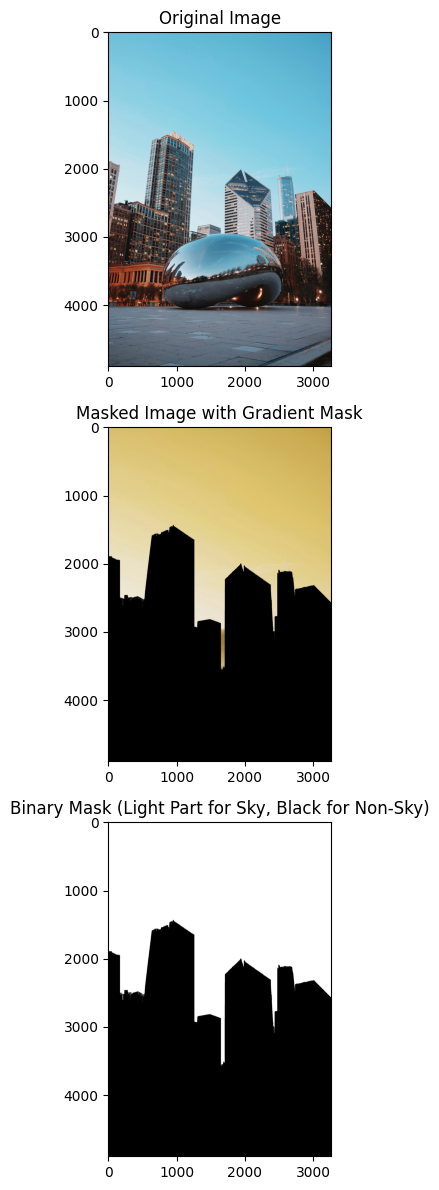

Processing Image: people.jpg


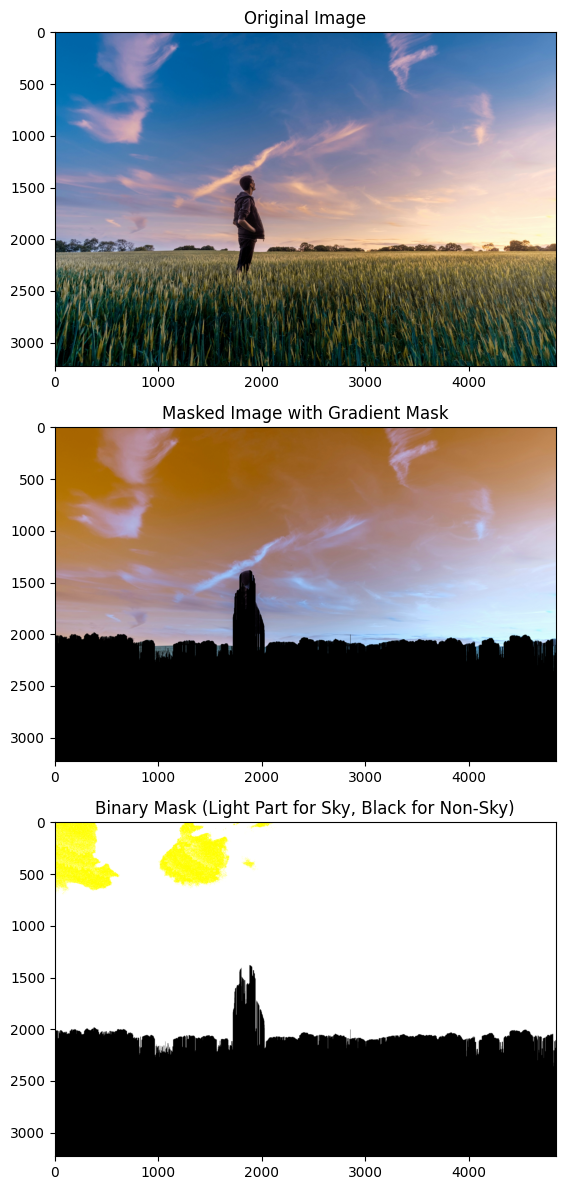

Processing Image: nyc.jpg


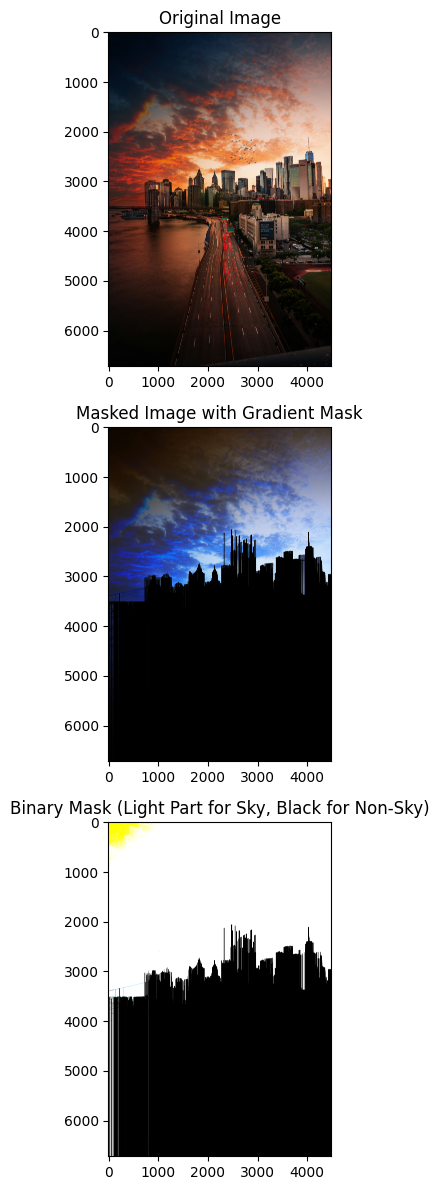

Processing Image: shanghai.jpg


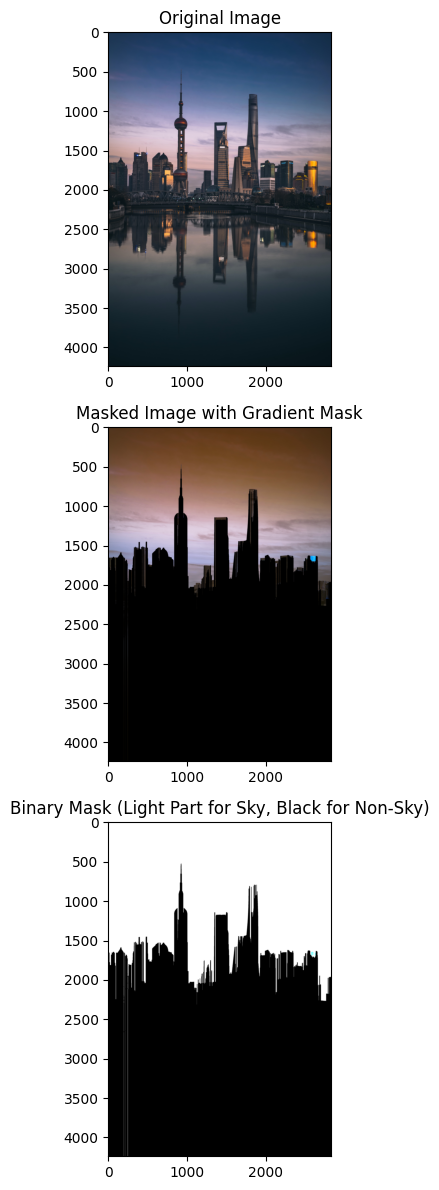

Processing Image: cloud.jpg


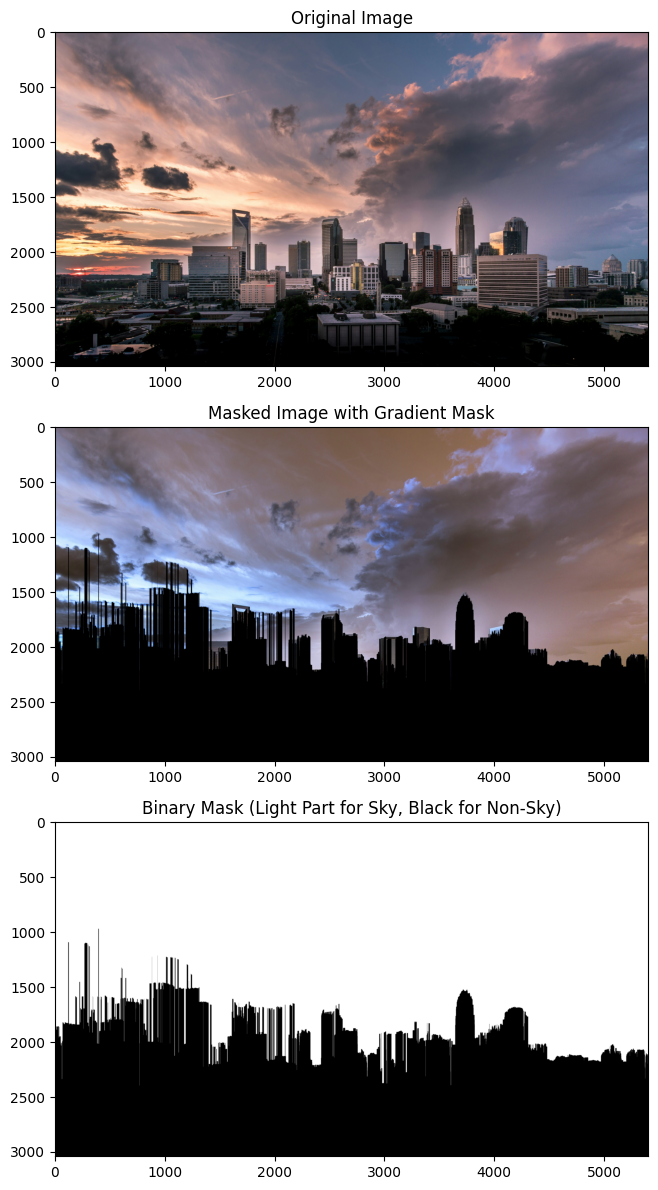

Processing Image: ice.jpg


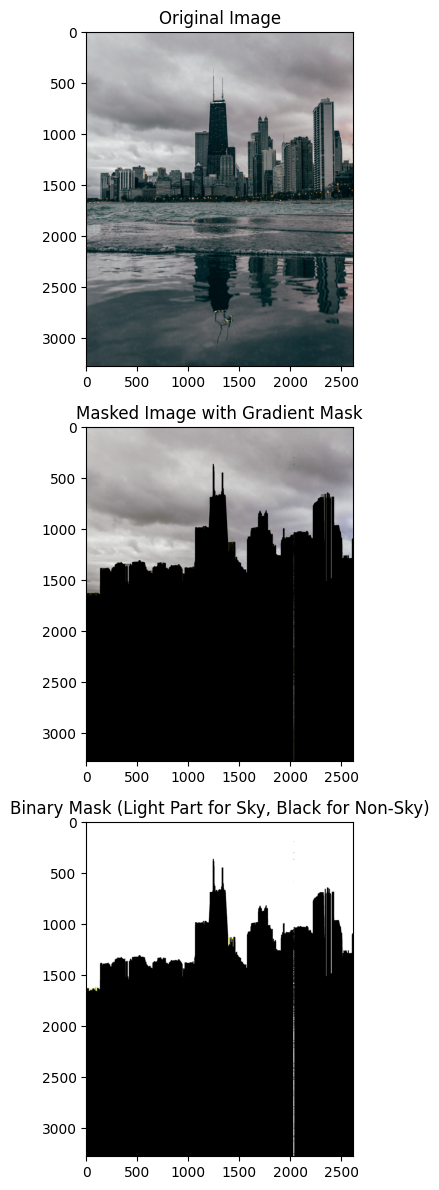

Processing Image: grass.jpg


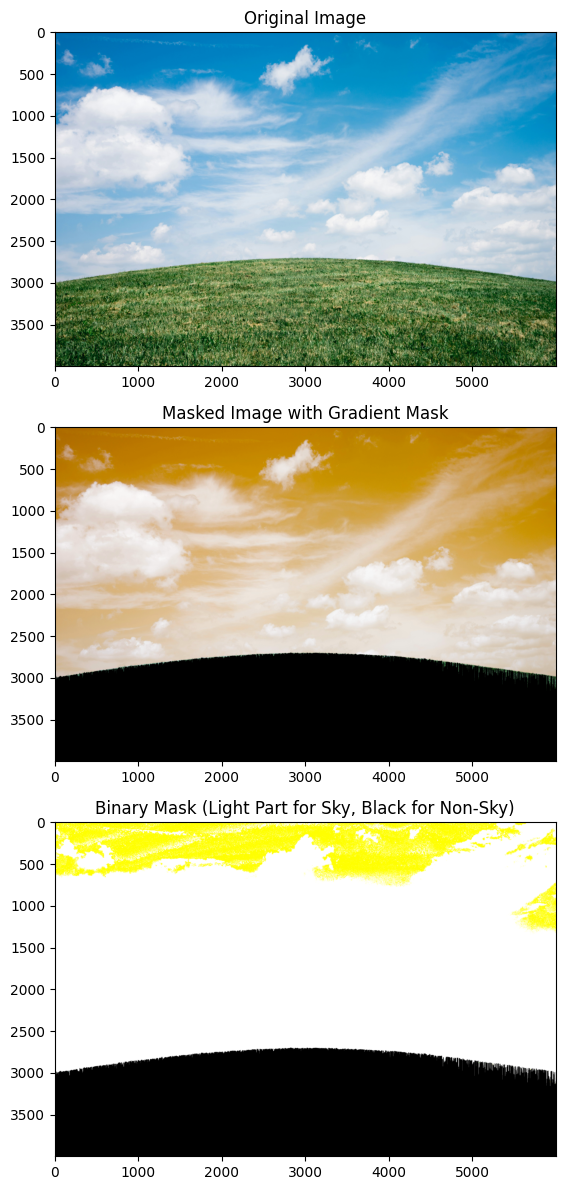

Processing Image: house.jpg


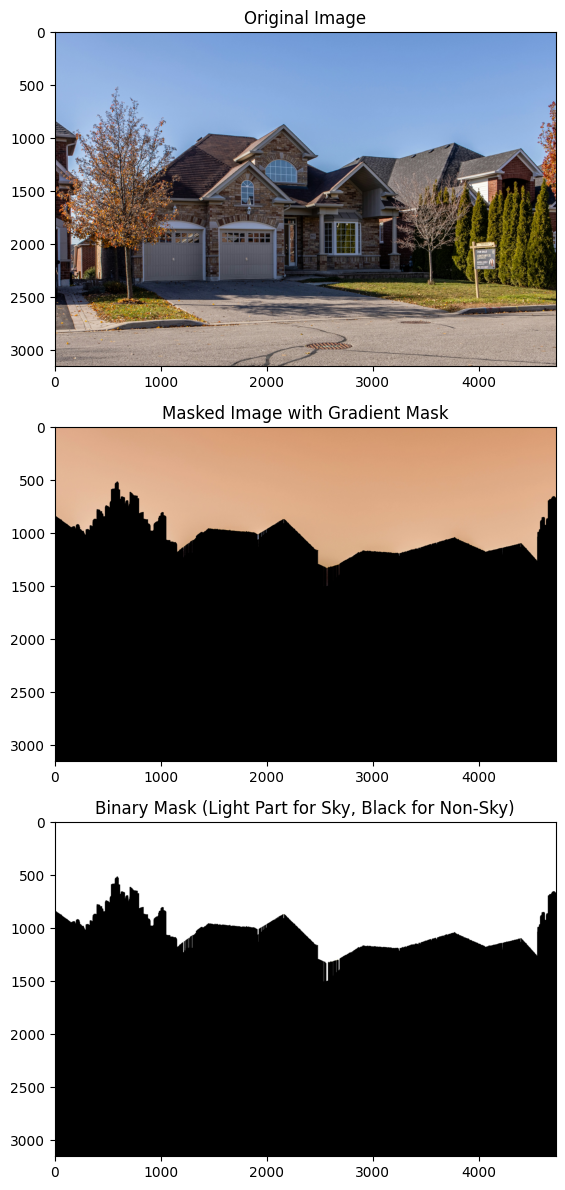

Processing Image: water.jpg


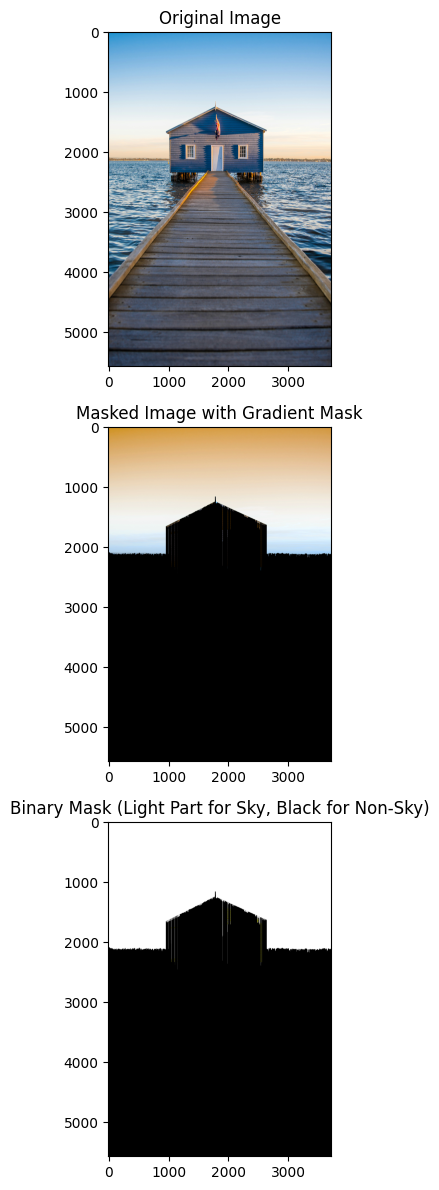

Processing Image: vancouver.jpg


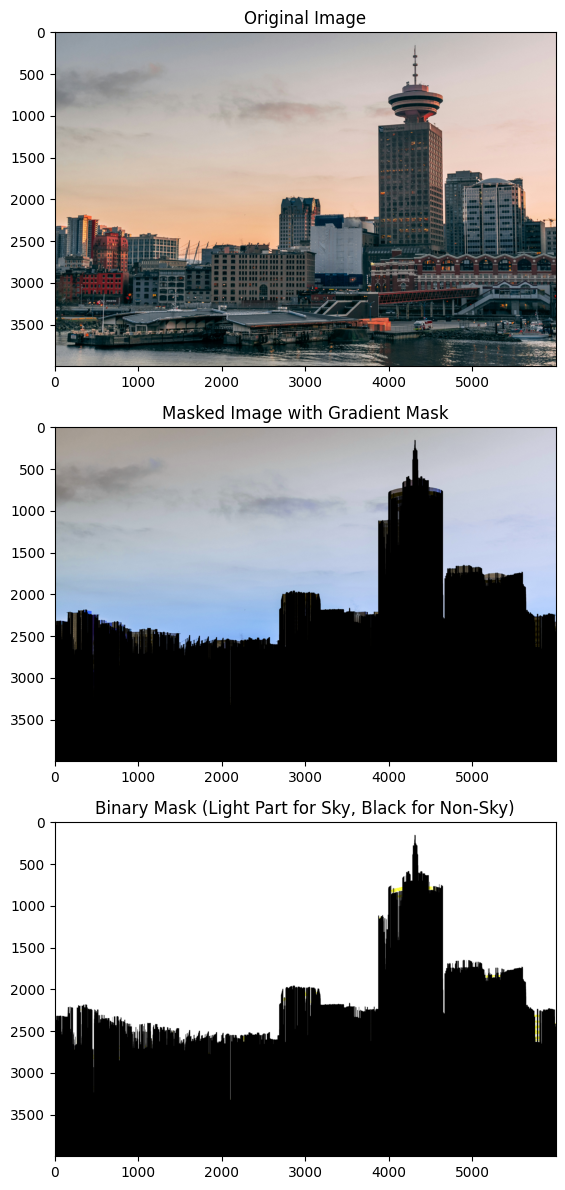

Processing Image: van.jpg


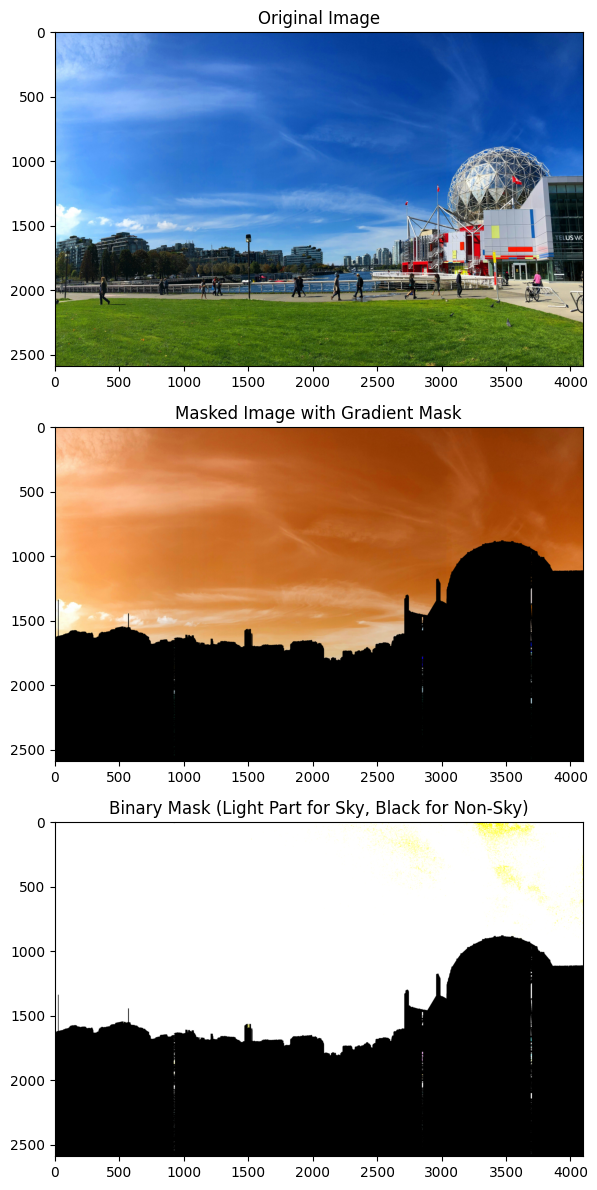

Processing Image: bridge.jpg


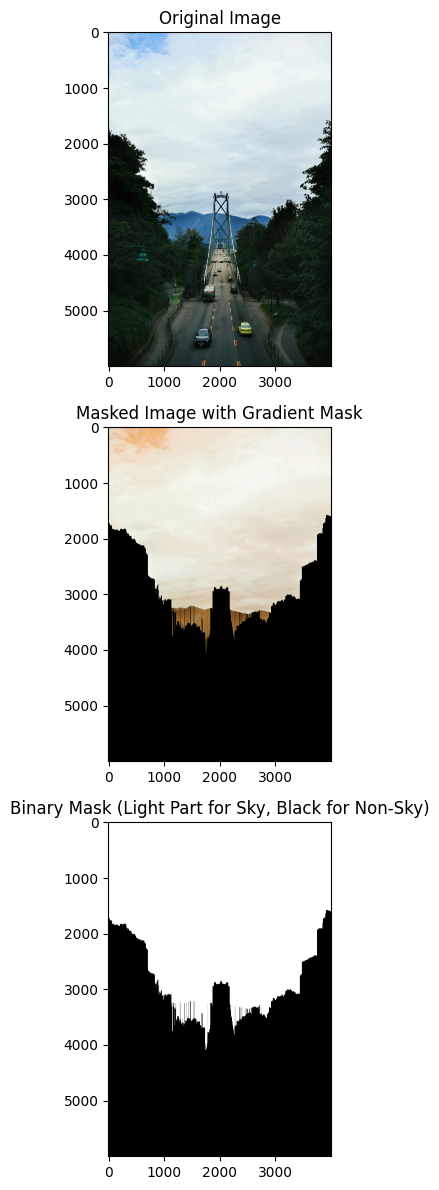

Processing Image: jersey.jpg


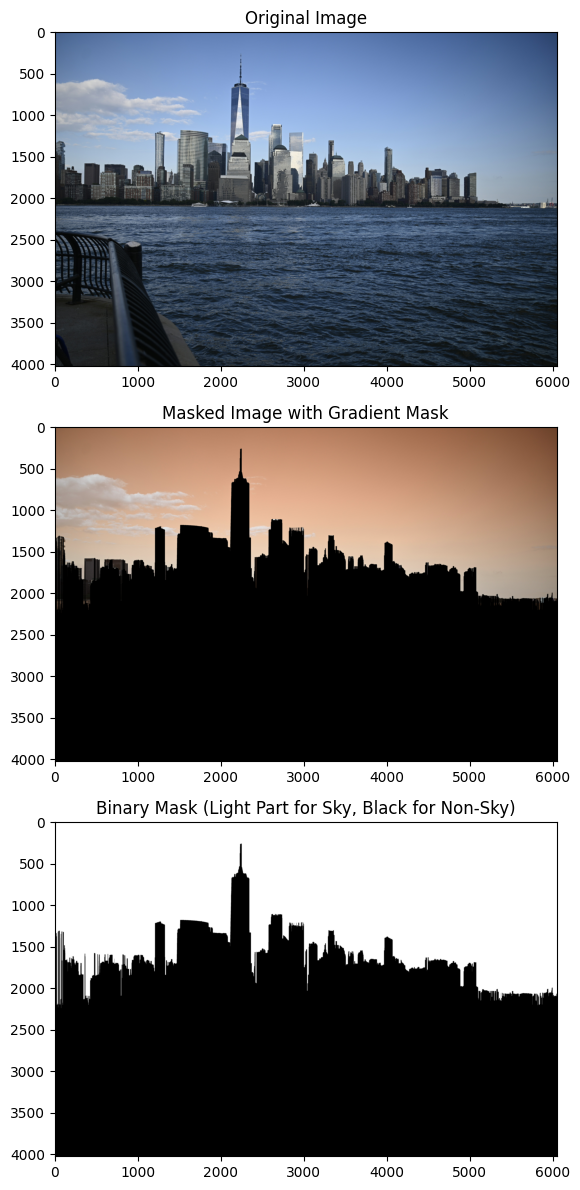

In [2]:
def test_images_in_folder(folder_path):
    """
    Test function to apply get_sky_region on each image in the specified folder.
    """
    # Get a list of image files in the folder
    image_files = [f for f in listdir(folder_path) if isfile(join(folder_path, f))]

    for image_file in image_files:
        # Construct the full path to the image
        image_path = join(folder_path, image_file)

        # Display the image file name
        print(f"Processing Image: {image_file}")

        # Apply get_sky_region function
        get_sky_region(image_path)

# Specify the folder path containing test images
test_folder_path = '/content/drive/My Drive/test_sky'

# Call the test function
test_images_in_folder(test_folder_path)